# **VaxMap Thailand: Analyzing Vaccination Coverage and Hospital Locations**

Welcome to the VaxMap Thailand project! My goal is to provide insights into the vaccination coverage among `children aged 1 year` across Thailand, leveraging geospatial data to map the distribution of hospitals. This project combines public health data with geospatial analytics to identify areas of high and low vaccine coverage and to visualize the accessibility of healthcare facilities across the country.

# Objectives:
- Assess vaccination coverage for various vaccines among children aged 1 year, ensuring they meet the recommended guidelines.
- Map hospital locations relative to population centers, identifying areas with potential healthcare accessibility issues.
- Visualize data through an interactive dashboard, making the information accessible and understandable for public health officials and the general public alike.


# Data Sources
Data obtained from [Ministry of Public Health's Open Data](https://opendata.moph.go.th/) from the following sources:

- Vaccination Coverage: "ความครอบคลุมการได้รับวัคซีนแต่ละชนิดครบตามเกณฑ์ในเด็กอายุครบ 1 ปี (fully immunized)" [Vaccination Coverage](https://opendata.moph.go.th/th/services/summary-table/4df360514655f79f13901ef1181ca1c7/s_epi_complete/28dd2c7955ce926456240b2ff0100bde).

- Hospital Coordinates: Essential for mapping and analysis [Hospital GIS](https://opendata.moph.go.th/th/services/hospital-gis).

- Map Service: Utilized for geospatial visualization. [Map Service](https://opendata.moph.go.th/th/services/map).

In [3]:
import requests
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import time

In [4]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)

# ER diagram

<img src="DBMLdiagram2.png" width="800"/>

<details>
    <summary>Click to toggle visibility of DBML code</summary>
    Table gdf1 {
  id integer [pk]
  geometry varchar
  data integer
  zone varchar
  name varchar
  type integer
}

Table gdf2 {
  id integer [pk]
  geometry varchar
  data integer
  zone varchar
  name varchar
  type integer
}

Table gdf3 {
  id integer [pk]
  geometry varchar
  data integer
  zone varchar
  name varchar
  type integer
}

Table hospital {
  hospcode integer [pk]
  name varchar
  prigov varchar
  type varchar
  org varchar
  region integer
  provcode integer
  prov varchar
  distcode integer
  dist varchar
  subdistcode integer
  subdist varchar
}

Table all_province_data {
  id varchar [pk]
  hospcode integer
  areacode varchar
  date_com varchar
  b_year integer
  target integer
  result integer
  // Assume other relevant fields are included
}

// Relationships
Ref: hospital.region > gdf1.id // A hospital is linked to a health region (gdf1)
Ref: hospital.provcode > gdf2.id // A hospital is located within a province (gdf2)
Ref: hospital.distcode > gdf3.id // A hospital is located within a district (gdf3)
Ref: all_province_data.hospcode > hospital.hospcode // all_province_data entries are related to a hospital
</details>


# Data Description

Below is a description of the dataset used in the VaxMap Thailand project, detailing the structure and meaning of each column:

| Column Name | Column Type | Nullable | Comment |
|-------------|-------------|----------|---------|
| id          | varchar(32) | NO       | ลำดับรายงาน (Report ID) |
| hospcode    | varchar(5)  | NO       | รหัสหน่วยบริการ (Hospital Code) |
| areacode    | varchar(8)  | NO       | รหัสพื้นที่ตามกระทรวงมหาดไทย (Area Code according to the Ministry of Interior) |
| date_com    | varchar(14) | YES      | วันที่ประมวลผล (Date Processed) |
| b_year      | varchar(4)  | NO       | ข้อมูลตามปีงบประมาณ (Budget/Fiscal Year of Data) |
| target      | int(11)     | YES      | จำนวนเด็กอายุครบ 1 ปี ที่อาศัยอยู่จริงในพื้นที่รับผิดชอบทั้งหมด ในงวดที่รายงาน (Total 1-year-old children living in the area for the reported period) |
| result      | int(11)     | YES      | จำนวนเด็กอายุครบ 1 ปี ในงวดที่รายงานที่ได้รับวัคซีนแต่ละชนิดครบตามเกณฑ์ (Number of 1-year-old children fully vaccinated as per guidelines for the reported period) |
| target10    | int(11)     | YES      | ... (similarly for other months, specifying the total target children for vaccination) |
| result10    | int(11)     | YES      | ... (similarly for other months, specifying the result of fully vaccinated children) |
| ...         | ...         | ...      | ... |
| target09    | int(11)     | YES      | จำนวนเด็กอายุครบ 1 ปี ที่อาศัยอยู่จริงในพื้นที่รับผิดชอบทั้งหมด ในงวดที่รายงาน เดือน พฤศจิกายน (Total 1-year-old children living in the area for November) |
| result09    | int(11)     | YES      | จำนวนเด็กอายุครบ 1 ปี ในงวดที่รายงานที่ได้รับวัคซีนแต่ละชนิดครบตามเกณฑ์ เดือน พฤศจิกายน (Number of 1-year-old children fully vaccinated as per guidelines for November) |



# [Hospital GIS](https://opendata.moph.go.th/th/services/hospital-gis) Web Service Documentation

## Parameter Description

| Attribute  | Attribute Type | Attribute Name                                         |
|------------|----------------|--------------------------------------------------------|
| `hoscode`  | String         | Health service facility code as announced by [THCC](http://thcc.or.th) |

## Response Description

The response includes detailed information about health service facilities, structured as follows:

| Attribute      | Attribute Type | Attribute Definition                                       |
|----------------|----------------|------------------------------------------------------------|
| `hoscode`      | String         | Health service facility code as announced by THCC          |
| `hosname`      | String         | Name of the health service facility                        |
| `hostype`      | String         | Type of health service facility                            |
| `bed`          | String         | Number of beds                                             |
| `dep`          | String         | Department affiliation                                     |
| `Level_service`| String         | Level of service                                           |
| `address`      | String         | Address                                                    |
| `moo`          | String         | Village number                                             |
| `subdistcode`  | String         | Sub-district code                                          |
| `distcode`     | String         | District code                                              |
| `provcode`     | String         | Province code                                              |
| `postcode`     | String         | Postal code                                                |
| `Geometry`     | String         | Geographical position                                      |


### Example Request

To request data for a specific health service facility identified by `hoscode`, use the following endpoint structure:

```url
https://opendata-service.moph.go.th/gis/v1/getgis/hoscode/00933



## `hoscode` code

### `health_office.csv`
provided by [Strategy and Planning Division](https://spd.moph.go.th/) from this [link](https://hcode.moph.go.th/dashboard/)

Select and store in `select_office.csv`
(Accessed on 10th FEB 2024)

In [5]:
# health_office_df = pd.read_csv("health_office.csv")

In [6]:
# # Strip unwanted characters and ensure correct format
# health_office_df['รหัส 5 หลัก'] = health_office_df['รหัส 5 หลัก'].str.replace('="', '').str.replace('"', '')
# health_office_df['รหัส 5 หลัก'] = health_office_df['รหัส 5 หลัก'].apply(lambda x: f"{int(x):05d}")

In [7]:
# # Export the DataFrame to a CSV file
# health_office_df.to_excel('health_office.xlsx', index=False)

In [8]:
# # Rename selected columns
# health_office_df.rename(columns={
#     'รหัส 5 หลัก': 'code5',
#     'ชื่อ': 'name',
#     'ประเภทองค์กร': 'prigov',
#     'ประเภทหน่วยบริการสุขภาพ': 'type',
#     'สังกัด': 'org',
#     'เขตบริการ': 'region',
#     'รหัสจังหวัด': 'provcode',
#     'จังหวัด': 'prov',
#     'รหัสอำเภอ': 'distcode',
#     'อำเภอ/เขต': 'dist',
#     'รหัสตำบล': 'subdistcode',
#     'ตำบล/แขวง': 'subdist',
#     'รหัสไปรษณีย์': 'postcode'}, inplace=True)

# # Drop missing value
# health_office_df = health_office_df.dropna(subset=['region'])

# # Extract integer region number from 'เขตบริการ', handling NaN safely
# health_office_df['region'] = health_office_df['region'].str.extract('(\d+)').astype(int).astype(str)

# # Ensure provcode, distcode, subdistcode are strings and remove any trailing '.0'
# columns_to_fix = ['provcode', 'distcode', 'subdistcode']
# for col in columns_to_fix:
#     health_office_df[col] = health_office_df[col].astype(int).astype(str)

# # Select relevant columns for the final DataFrame
# selected_office_df = health_office_df[['code5', 'name', 'prigov', 'type', 'org', 'region', 'provcode', 'prov', 'distcode', 'dist', 'subdistcode', 'subdist']]

# selected_office_df.head()

In [9]:
# selected_office_df.info()

In [10]:
# # Export the DataFrame to a CSV file
# selected_office_df.to_csv('selected_office.csv', index=False)

### Get all `hoscode` from `hospcode` of report_data and store in `hospcode_list.csv`

In [11]:
# import requests
# import json

# # Base URL for the RESTful Web Service
# url = "https://opendata.moph.go.th/api/report_data"

# # The headers to indicate that the payload is in JSON format
# headers = {
#     "Content-Type": "application/json"
# }

# # Initialize a variable to store data for all provinces
# all_province_data = []

# # Loop through province codes 11 to 99
# for province_code in range(11, 100):
#     # The data you want to send in the POST request
#     data = {
#         "tableName": "s_epi_complete",
#         "year": "2567",  # Specify other years as needed
#         "province": str(province_code),
#         "type": "json"
#     }

#     # Making the POST request
#     response = requests.post(url, headers=headers, data=json.dumps(data))

#     # Checking if the request was successful
#     if response.status_code in [200, 201]:
#         # The request was successful; process and store the response data
#         print(f"Data retrieved successfully for province code {province_code}!")
#         all_province_data.append(response.json())
#     else:
#         # There was an error with the request
#         print(f"Failed to retrieve data for province code {province_code}. Status code: {response.status_code}")

#     # Consider adding a short delay if necessary to avoid overwhelming the server or hitting rate limits
#     time.sleep(0.1)

In [12]:
# all_province_data

In [13]:
# # Initialize a set to store unique hospcode values
# unique_hospcode_set = set()

# # Iterate through each response (assuming each response is a list of dictionaries)
# for response in all_province_data:
#     for hospital_data in response:
#         # Extract the hospcode and add it to the set
#         unique_hospcode_set.add(hospital_data['hospcode'])

# # Convert the set to a list if you need an ordered collection
# unique_hospcode_list = list(unique_hospcode_set)

# print(unique_hospcode_list)

In [14]:
# # Convert the set of unique hospcode values to a DataFrame for easy export
# unique_hospcode_df = pd.DataFrame(unique_hospcode_list, columns=['hospcode'])

# # Export the DataFrame to a CSV file
# unique_hospcode_df.to_csv('hospcode_list.csv', index=False)

In [15]:
# # Convert the set of unique hospcode values to a DataFrame for easy export
# unique_hospcode_df = pd.DataFrame(unique_hospcode_list, columns=['hospcode'])

# # Export the DataFrame to a Excel file
# unique_hospcode_df.to_excel('hospcode_list.xlsx', index=False)

### Create new `hospital_df` from `hospcode_list` left join with `selected_office`

In [16]:
# Load the hospcode list and selected office data from CSV files
hospcode_list_df = pd.read_csv('hospcode_list.csv', dtype={'hospcode': str})
selected_office_df = pd.read_csv('selected_office.csv', dtype={'code5': str,
                                                               'region': str,
                                                               'provcode': str,
                                                               'distcode': str,
                                                               'subdistcode': str})

# Perform a left join on 'hospcode' from hospcode_list_df and 'code5' from selected_office_df
hospital_df = pd.merge(hospcode_list_df, selected_office_df, left_on='hospcode', right_on='code5', how='left')
hospital_df.drop(columns=['code5'], inplace=True)

# Display the first few rows of the joined DataFrame
hospital_df.head()

,hospcode,name,prigov,type,org,region,provcode,prov,distcode,dist,subdistcode,subdist
0,01958,โรงพยาบาลส่งเสริมสุขภาพตำบลบ้านนา,รัฐบาล,ศูนย์บริการสาธารณสุข อปท.,องค์กรปกครองส่วนท้องถิ่น,6,21,ระยอง,2103,แกลง,210308,บ้านนา
1,05621,โรงพยาบาลส่งเสริมสุขภาพตำบลบ้านโคกสว่าง ตำบลโค...,รัฐบาล,โรงพยาบาลส่งเสริมสุขภาพตำบล,กระทรวงสาธารณสุข,8,48,นครพนม,4802,ปลาปาก,480204,โคกสว่าง
2,10450,โรงพยายาบส่งเสริมสุขภาพตำบลบ้านโป่งกลางน้ำ,รัฐบาล,ศูนย์บริการสาธารณสุข อปท.,องค์กรปกครองส่วนท้องถิ่น,1,57,เชียงราย,5710,แม่สรวย,571006,วาวี
3,01748,โรงพยาบาลส่งเสริมสุขภาพตำบลบ้านหลวง,รัฐบาล,โรงพยาบาลส่งเสริมสุขภาพตำบล,กระทรวงสาธารณสุข,4,19,สระบุรี,1907,ดอนพุด,190703,บ้านหลวง
4,01612,โรงพยาบาลส่งเสริมสุขภาพตำบลบ้านธัญญอุดม,รัฐบาล,โรงพยาบาลส่งเสริมสุขภาพตำบล,กระทรวงสาธารณสุข,3,18,ชัยนาท,1801,เมืองชัยนาท,180106,หาดท่าเสา


In [38]:
# # Export the DataFrame to a CSV file
# hospital_df.to_csv('hospital.csv', index=False)

# [Map Service](https://opendata.moph.go.th/th/services/map) Data Response Structure

The Map Service provides GeoJSON data for various administrative divisions in Thailand, including health districts, provinces, and districts. Below is the description of the response attributes from the GeoJSON service endpoint.

| Attribute                     | Attribute Type | Attribute Definition |
|-------------------------------|----------------|----------------------|
| `features`                    | JSON Object    | A collection of data used to create maps. |
| `features.geometry`           | JSON Object    | The data set that forms the map shape file, including latitude and longitude coordinates. |
| `features.geometry.type`      | String         | The type of shape. |
| `features.geometry.coordinates` | String       | An array of latitude and longitude coordinates that form the shape of each area. |
| `features.type`               | String         | The type of feature. |
| `features.properties`         | JSON Object    | Additional data related to the feature. |
| `features.properties.name`    | String         | The name or details about the shape file. |
| `features.properties.id`      | String         | The ID code of the shape file. |
| `features.properties.type`    | String         | The type of the shape file. |
| `features.type`               | String         | The type of Features. |

## Data Endpoints

- **Health Districts (เขตสุขภาพ)**: `https://opendata-service.moph.go.th/gis/v1/geojson/1`
- **Provinces (จังหวัด)**: `https://opendata-service.moph.go.th/gis/v1/geojson/2`
- **Districts (อำเภอ)**: `https://opendata-service.moph.go.th/gis/v1/geojson/3`

## Fetch the GeoJSON Data

### Level 1: เขตสุขภาพ Region

In [50]:
import requests
import geopandas as gpd

# URL for the GeoJSON data
url = 'https://opendata-service.moph.go.th/gis/v1/geojson/1'

# Fetch the GeoJSON data
response = requests.get(url)
geojson = response.json()

# Load GeoJSON into a GeoDataFrame
gdf1 = gpd.GeoDataFrame.from_features(geojson['features'])

In [43]:
gdf1

,geometry,data,zone,name,id,type
0,"MULTIPOLYGON (((98.69195 17.77530, 98.68068 17...",80,,เขตสุขภาพที่ 01,01,1
1,"MULTIPOLYGON (((101.26396 17.08764, 101.27981 ...",80,,เขตสุขภาพที่ 02,02,1
2,"MULTIPOLYGON (((100.34397 15.10966, 100.29725 ...",80,,เขตสุขภาพที่ 03,03,1
3,"MULTIPOLYGON (((101.28452 14.49621, 101.28632 ...",80,,เขตสุขภาพที่ 04,04,1
4,"MULTIPOLYGON (((98.59070 15.64435, 98.62094 15...",80,,เขตสุขภาพที่ 05,05,1
5,"MULTIPOLYGON (((102.25305 12.28667, 102.24917 ...",80,,เขตสุขภาพที่ 06,06,1
6,"MULTIPOLYGON (((103.58606 17.09754, 103.62259 ...",80,,เขตสุขภาพที่ 07,07,1
7,"MULTIPOLYGON (((102.09970 18.21428, 102.11396 ...",80,,เขตสุขภาพที่ 08,08,1
8,"MULTIPOLYGON (((101.57202 16.72447, 101.58926 ...",80,,เขตสุขภาพที่ 09,09,1
9,"MULTIPOLYGON (((104.98066 16.27747, 105.01872 ...",80,,เขตสุขภาพที่ 10,10,1


In [44]:
# # Export the DataFrame to a CSV file
# gdf1.to_csv('gdf1.csv', index=False)

### Level 2: จังหวัด Province

In [45]:
import requests
import geopandas as gpd

# URL for the GeoJSON data
url = 'https://opendata-service.moph.go.th/gis/v1/geojson/2'

# Fetch the GeoJSON data
response = requests.get(url)
geojson = response.json()

# Load GeoJSON into a GeoDataFrame
gdf2 = gpd.GeoDataFrame.from_features(geojson['features'])

In [46]:
gdf2

,geometry,data,zone,name,id,type
0,"POLYGON ((100.55902 13.91443, 100.57404 13.954...",80,,กรุงเทพมหานคร,10,2
1,"POLYGON ((100.59733 13.53899, 100.55342 13.504...",80,,สมุทรปราการ,11,2
2,"POLYGON ((100.55035 13.87748, 100.54376 13.849...",80,,นนทบุรี,12,2
3,"POLYGON ((100.46971 13.96625, 100.35569 14.000...",80,,ปทุมธานี,13,2
4,"POLYGON ((100.45491 14.11890, 100.34429 14.115...",80,,พระนครศรีอยุธยา,14,2
...,...,...,...,...,...,...
72,"MULTIPOLYGON (((99.49066 7.35269, 99.48354 7.2...",80,,ตรัง,92,2
73,"MULTIPOLYGON (((100.39970 7.26496, 100.38390 7...",80,,พัทลุง,93,2
74,"MULTIPOLYGON (((101.32271 6.92791, 101.30151 6...",80,,ปัตตานี,94,2
75,"POLYGON ((101.38779 6.33559, 101.40332 6.23924...",80,,ยะลา,95,2


In [47]:
# # Export the DataFrame to a CSV file
# gdf2.to_csv('gdf2.csv', index=False)

### Level 3: อำเภอ District

In [55]:
import requests
import geopandas as gpd

# URL for the GeoJSON data
url = 'https://opendata-service.moph.go.th/gis/v1/geojson/3'

# Fetch the GeoJSON data
response = requests.get(url)
geojson = response.json()

# Ensure each feature has a 'geometry' key
for feature in geojson['features']:
    if 'geometry' not in feature:
        feature['geometry'] = None  # or an appropriate default value

# Now, attempt to load the GeoJSON into a GeoDataFrame
gdf3 = gpd.GeoDataFrame.from_features(geojson['features'])

# If the above doesn't resolve the KeyError, print out the problematic features
# This is for debugging purposes
for i, feature in enumerate(geojson['features']):
    if 'geometry' not in feature:
        print(f"Feature at index {i} is missing 'geometry': {feature}")

In [56]:
gdf3

,geometry,data,zone,name,id,type
0,"MULTIPOLYGON (((100.49910 13.74493, 100.49016 ...",80,,พระนคร,1001,3
1,"MULTIPOLYGON (((100.51851 13.80202, 100.53607 ...",80,,ดุสิต,1002,3
2,"MULTIPOLYGON (((100.91400 13.93371, 100.90740 ...",80,,หนองจอก,1003,3
3,"MULTIPOLYGON (((100.52193 13.72298, 100.51068 ...",80,,บางรัก,1004,3
4,"MULTIPOLYGON (((100.61126 13.88885, 100.65247 ...",80,,บางเขน,1005,3
...,...,...,...,...,...,...
987,"MULTIPOLYGON (((102.04683 6.14443, 102.06540 6...",80,,สุไหงโก-ลก,9610,3
988,"MULTIPOLYGON (((101.92505 6.22168, 102.02249 6...",80,,สุไหงปาดี,9611,3
989,"MULTIPOLYGON (((101.70986 6.18786, 101.71491 6...",80,,จะแนะ,9612,3
990,"MULTIPOLYGON (((101.85486 6.29823, 101.89596 6...",80,,เจาะไอร้อง,9613,3


In [57]:
# # Export the DataFrame to a CSV file
# gdf3.to_csv('gdf3.csv', index=False)

# Vaccine coverage API

In [31]:
# The URL of the RESTful Web Service
url = "https://opendata.moph.go.th/api/report_data"

# The data you want to send in the POST request
data = {
    "tableName": "s_epi_complete",
    "year": "2567", # starting at 2556 BE
    "province": "11", # starting from 11-96 exclude 10 (Bangkok, which is เขตสุขภาพที่ 13) and 28/29/59/68/69/78/79/87/88/89 (null)
    "type": "json"
}

# Setting the headers to indicate that the payload is in JSON format
headers = {
    "Content-Type": "application/json"
}

# Making the POST request
response = requests.post(url, headers=headers, data=json.dumps(data))

# Checking if the request was successful
if response.status_code in [200, 201]:
    # The request was successful; you can process the response data
    print("Data retrieved successfully!")
    #print(response.json())  # This will print the response data as a Python dictionary
else:
    # There was an error with the request
    print(f"Failed to retrieve data. Status code: {response.status_code}")

Failed to retrieve data. Status code: 400


In [23]:
# Convert the JSON response to a pandas DataFrame
data = response.json()
df = pd.json_normalize(data)
# Display the first few rows to verify the DataFrame structure
df.head()

,id,hospcode,areacode,date_com,b_year,target,result,target10,result10,target11,result11,target12,result12,target01,result01,target02,result02,target03,result03,target04,result04,target05,result05,target06,result06,target07,result07,target08,result08,target09,result09
0,d1fe173d08e959397adf34b1d77e88d7,00933,11010204,202402101526,2567,50,38,8,8,6,6,2,2,5,4,3,3,2,1,2,2,4,4,4,4,6,4,3,0,5,0
1,35f4a8d465e6e1edc05f3d8ab658c551,00933,11010204,202402101526,2567,42,24,6,4,2,1,5,5,4,4,4,3,4,3,1,0,2,1,4,2,1,1,3,0,6,0
2,f033ab37c30201f73f142449d037028d,00933,11010203,202402101526,2567,55,39,5,3,6,3,5,2,2,1,6,4,4,1,5,4,3,3,3,3,4,4,5,4,7,7
3,f033ab37c30201f73f142449d037028d,00933,11010204,202402101526,2567,41,30,3,3,1,0,3,2,4,1,1,0,5,1,4,4,5,4,2,2,5,5,6,6,2,2
4,35f4a8d465e6e1edc05f3d8ab658c551,00933,11010203,202402101526,2567,30,15,3,3,3,2,4,3,1,1,1,1,2,1,3,1,0,0,2,1,2,2,7,0,2,0


In [70]:
# Base URL for the RESTful Web Service
url = "https://opendata.moph.go.th/api/report_data"

# Headers indicating that the payload is in JSON format
headers = {"Content-Type": "application/json"}

# List of all province codes excluding specific ones
# starting from 11-96 exclude 10 (Bangkok, which is เขตสุขภาพที่ 13) and 28/29/59/68/69/78/79/87/88/89 (null)
excluded_provinces = ['10', '28', '29', '59', '68', '69', '78', '79', '87', '88', '89']
province_codes = [f"{i:02d}" for i in range(11, 97) if f"{i:02d}" not in excluded_provinces]

# Initialize a DataFrame to store all data
all_province_data = pd.DataFrame()

for province_code in province_codes:
    # Data payload for the POST request
    data = {
        "tableName": "s_epi_complete",
        "year": "2567",  # Specify other years as needed
        "province": province_code,
        "type": "json"
    }

    # Make the POST request
    response = requests.post(url, headers=headers, data=json.dumps(data))

    # Check if the request was successful
    if response.status_code in [200, 201]:
        # Convert the JSON response to a pandas DataFrame and append to the all_province_data DataFrame
        temp_df = pd.json_normalize(response.json())
        all_province_data = pd.concat([all_province_data, temp_df], ignore_index=True)
    else:
        print(f"Failed to retrieve data for province code {province_code}. Status code: {response.status_code}")

In [77]:
all_province_data.head()

,id,hospcode,areacode,date_com,b_year,target,result,target10,result10,target11,result11,target12,result12,target01,result01,target02,result02,target03,result03,target04,result04,target05,result05,target06,result06,target07,result07,target08,result08,target09,result09
0,f033ab37c30201f73f142449d037028d,00933,11010204,202402111558,2567,41,30,3,3,1,0,3,2,4,1,1,0,5,1,4,4,5,4,2,2,5,5,6,6,2,2
1,28dd2c7955ce926456240b2ff0100bde,00933,11010203,202402111558,2567,20,9,2,2,1,1,2,2,2,2,1,1,0,0,2,1,1,0,4,0,4,0,0,0,1,0
2,d1fe173d08e959397adf34b1d77e88d7,00933,11010204,202402111558,2567,50,38,8,8,6,6,2,2,5,4,3,3,2,1,2,2,4,4,4,4,6,4,3,0,5,0
3,28dd2c7955ce926456240b2ff0100bde,00933,11010204,202402111558,2567,28,15,1,1,1,1,5,5,5,3,2,1,2,2,2,2,2,0,2,0,2,0,3,0,1,0
4,f033ab37c30201f73f142449d037028d,00933,11010203,202402111558,2567,55,39,5,3,6,3,5,2,2,1,6,4,4,1,5,4,3,3,3,3,4,4,5,4,7,7


In [41]:
# # Export the DataFrame to a CSV file
# all_province_data.to_csv('all_province_data.csv', index=False)

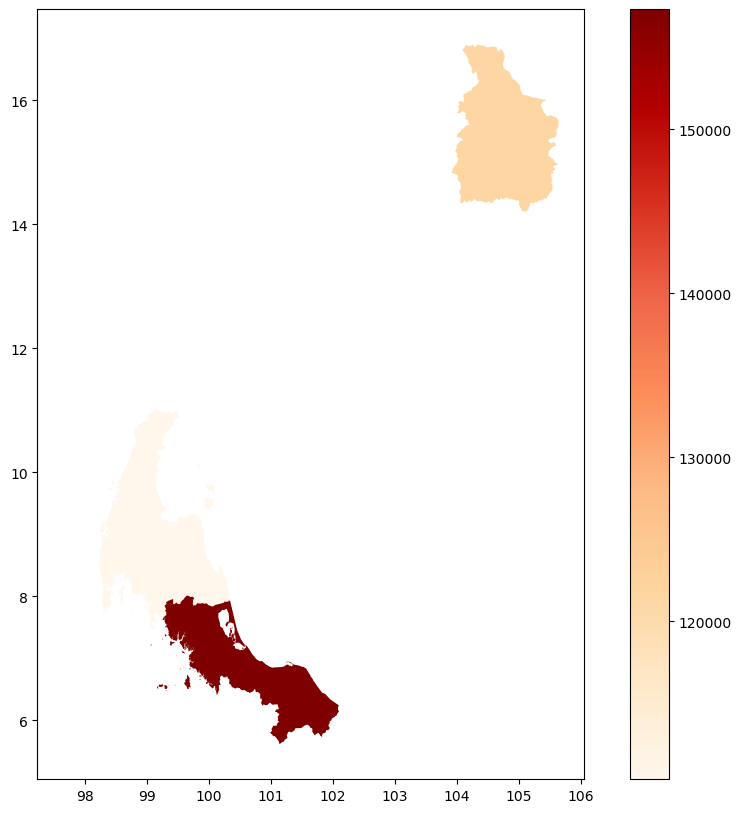

In [76]:
import matplotlib.pyplot as plt
import geopandas as gpd

# First, we need to merge the all_province_data with the hospital data to get the region information.
all_province_data_hospital_merged = pd.merge(all_province_data, hospital_df[['hospcode', 'region']], on='hospcode', how='left')

# Now we need to aggregate this merged data at the regional level.
# We can sum up the 'target' column as an example metric to aggregate.
regional_aggregate = all_province_data_hospital_merged.groupby('region')['target'].sum().reset_index()

# Next, we need to merge this aggregated data with gdf1 on the 'id' which represents the region.
gdf1_merged = pd.merge(gdf1, regional_aggregate, left_on='id', right_on='region', how='left')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf1_merged.plot(column='target', ax=ax, legend=True, cmap='OrRd')
plt.show()